In [1]:
from io import BytesIO
from PyPDF2 import PdfFileReader
import requests
import re
import pandas as pd
from datetime import datetime as dt
import datetime
import os

In [2]:
#import kmeansct

raw_data_path = os.path.join(os.path.pardir,"data","raw","CaseCountData_texas.csv")
zip_data_path = os.path.join(os.path.pardir,"data","raw","zipMap.csv")
raw_data_path_daily_rate = os.path.join(os.path.pardir,"data","raw","case_counts_daily_rate.csv")
predictions_data_band = os.path.join(os.path.pardir,"data","processed","predictions","predictions_bands.csv")
predictions_data_path_zip = os.path.join(os.path.pardir,"data","processed","predictions","predictions_daily_rate_zip.csv")
predictions_data_path = os.path.join(os.path.pardir,"data","processed","predictions","predictions_tx.csv")
predictions_data_path_cumulative = os.path.join(os.path.pardir,"data","processed","predictions","predictions_cumulative.csv")
predictions_data_path_daily_rate = os.path.join(os.path.pardir,"data","processed","predictions","predictions_daily_rate_1d.csv")

In [3]:
def get_cumulative_count_pdf_date():
    today_weekday = dt.weekday(dt.today())

    if (today_weekday > 0) and (today_weekday < 6):
        pdf_extract_day = -1
    elif today_weekday == 0:
        pdf_extract_day = -3
    elif today_weekday == 6:
        pdf_extract_day = -2
    else:
        raise Exception("Weekday out of range :{}".format(today_weekday))

    pdf_date = dt.today() + datetime.timedelta(days=pdf_extract_day)
    pdf_date_str = dt.strftime(pdf_date, "%m%d%Y")[1:]

    return pdf_date_str

In [4]:
get_cumulative_count_pdf_date()

'9222020'

In [5]:
def ct_cumulative_counts():
    data_list=[]
    #today = datetime.strftime(datetime.today(),"%m%d%Y")[1:]
    today = get_cumulative_count_pdf_date()
    print(today)
    #url="https://portal.ct.gov/-/media/Coronavirus/CTDPHCOVID19summary9112020.pdf"
    url="https://portal.ct.gov/-/media/Coronavirus/CTDPHCOVID19summary{}.pdf".format(today)
    print(url)
    ###########################################
    #uncomment  below lines for today's gove data
    pdf_data = requests.get(url)
    pdf_content = BytesIO(pdf_data.content)
    reader = PdfFileReader(pdf_content)
    ###################################
    #REmove below 2 lines for actual today's gov data"
    #pdffile=open(r"c:\users\babub\downloads\CTDPHCOVID19summary9112020.pdf","rb")
    #reader = PdfFileReader(pdffile)
    ###############################################
    for eachpage in range (4,5):
        try:
            case_count_page = reader.getPage(eachpage).extractText()
            if len(re.findall("Cumulative Number of COVID",case_count_page)) > 0:
                case_counts = re.findall("Andover[\s\S]+Preston",case_count_page)[0]
                #city_counts = re.findall("\S+[\n ]+[\n]+\S+[\n ]+[\n]+\S+[\n ]+[\n]+",case_counts)
                city_counts = re.findall("\S+?\s*\S*[\n ]+[\n]+\S+[\n ]+[\n]+\S+[\n ]+[\n]+",case_counts)
                for each_city in city_counts:
                    try:
                        int(re.split("[\n ]+[\n]+",each_city)[1])
                        data_list.append(re.split("[\n ]+[\n]+",each_city)[0:3])
                    except:
                        pass
                
                df =pd.DataFrame(data_list,columns=["city","case_counts","probable_counts"])
                df.to_csv(raw_data_path,header=True,index=None)
        except Exception as e:
            print("Exception occurred",e)

In [6]:
ct_cumulative_counts()

9222020
https://portal.ct.gov/-/media/Coronavirus/CTDPHCOVID19summary9222020.pdf


In [7]:
df = pd.read_csv(raw_data_path)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 3 columns):
city               166 non-null object
case_counts        166 non-null int64
probable_counts    166 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.0+ KB


In [9]:
X_data = df.loc[0:,['case_counts']]
print(X_data.head())

   case_counts
0           10
1           52
2           78
3          307
4          190


In [10]:
from sklearn.cluster import KMeans

#WCSS within cluster sum of squares - sum of the distances of observation from cluster centroids. We will use this to find elbow point
wcss=[]

In [11]:
#loop and fit KMeans multiple times to calculate WCSS for each pass of k value
for i in range(1,11):
    clf = KMeans(n_clusters=i, init='k-means++',max_iter=1000,n_init=10)
    
    clf.fit(X_data)
    wcss.append(clf.inertia_)
print(len(wcss))
print(wcss)

10
[67133011.95783134, 14649341.311769987, 5886794.815005138, 3873875.581481478, 2373501.5648754933, 1582072.01937291, 990809.1918174183, 703935.4110265269, 553574.2443598602, 413593.4431372547]


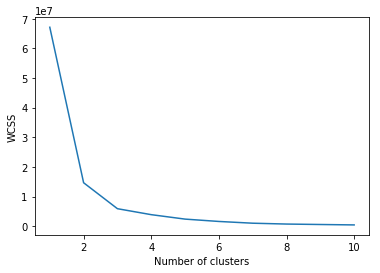

In [12]:
#plot the elbow graph
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(1,11),wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [18]:
#scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_data = scaler.fit_transform(X_data)

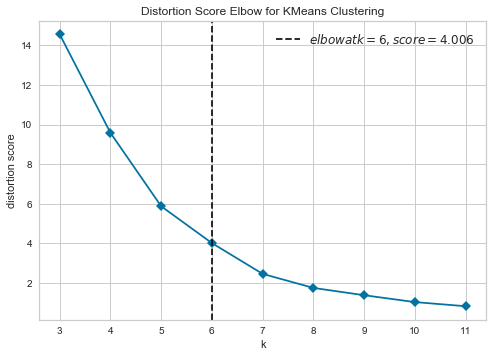

In [19]:
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(3,12), timings=False)
visualizer.fit(X_data)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [14]:
#as per above fig it should be k=3
clf = KMeans(n_clusters=6, init='k-means++',max_iter=1000,n_init=10,random_state=0)
kmeans = clf.fit(X_data)
centers = pd.DataFrame(clf.cluster_centers_,columns=['centroids'])
print(centers)
Y_data = kmeans.predict(X_data)

     centroids
0    47.677083
1  1103.000000
2  2659.400000
3   673.000000
4  3860.000000
5   267.139535


In [17]:
print(df.head())
print(clf.labels_)

       city  case_counts  probable_counts
0   Andover           10                0
1  Griswold           52                2
2  Prospect           78                0
3   Ansonia          307                8
4    Groton          190               15
[0 0 0 5 5 0 0 0 0 5 0 5 0 1 5 0 0 0 5 2 0 0 0 0 5 0 0 0 0 5 3 0 0 0 0 3 0
 0 0 5 0 0 4 0 5 0 0 5 3 0 5 5 0 5 5 5 0 0 3 0 0 5 4 0 0 0 0 1 0 0 0 1 5 0
 5 0 3 0 0 3 0 0 0 0 0 5 3 0 0 3 0 5 0 0 1 5 0 5 0 2 0 3 5 0 0 0 2 0 5 5 2
 0 5 5 0 5 5 0 5 3 0 0 1 1 0 0 5 0 0 5 5 5 5 0 5 0 2 0 0 5 5 0 3 0 5 0 0 3
 3 0 0 5 0 0 0 5 0 5 0 0 0 0 0 0 0 1]


In [25]:
#rank centroids df
centers['group_rank'] = centers['centroids'].rank(ascending=True)
centers['group'] = pd.Series(centers.index.tolist())
print(centers)

     centroids  group_rank  group
0    47.677083         1.0      0
1  1103.000000         4.0      1
2  2659.400000         5.0      2
3   673.000000         3.0      3
4  3860.000000         6.0      4
5   267.139535         2.0      5


In [27]:
#predictions_data_path
Y_df = pd.DataFrame(Y_data)
Y_df.columns=["group"]
print(Y_df)

     group
0        0
1        0
2        0
3        5
4        5
5        0
6        0
7        0
8        0
9        5
10       0
11       5
12       0
13       1
14       5
15       0
16       0
17       0
18       5
19       2
20       0
21       0
22       0
23       0
24       5
25       0
26       0
27       0
28       0
29       5
..     ...
136      2
137      0
138      0
139      5
140      5
141      0
142      3
143      0
144      5
145      0
146      0
147      3
148      3
149      0
150      0
151      5
152      0
153      0
154      0
155      5
156      0
157      5
158      0
159      0
160      0
161      0
162      0
163      0
164      0
165      1

[166 rows x 1 columns]


In [36]:
predicted_df = pd.concat([df.iloc[0:,0:3],Y_df],axis=1)
predicted_df = predicted_df.merge(centers,how='inner',left_on='group',right_on='group')
predicted_df.insert(0,'state','CT')

In [37]:
predicted_df.head(20)

,state,city,case_counts,probable_counts,group,centroids,group_rank
0,CT,Andover,10,0,0,47.677083,1.0
1,CT,Griswold,52,2,0,47.677083,1.0
2,CT,Prospect,78,0,0,47.677083,1.0
3,CT,Putnam,43,1,0,47.677083,1.0
4,CT,Ashford,24,1,0,47.677083,1.0
5,CT,Guilford,129,10,0,47.677083,1.0
6,CT,Redding,75,7,0,47.677083,1.0
7,CT,Haddam,47,1,0,47.677083,1.0
8,CT,Barkhamsted,31,2,0,47.677083,1.0
9,CT,Beacon Falls,62,0,0,47.677083,1.0


In [38]:
predicted_df.to_csv(predictions_data_path_cumulative,index=None)

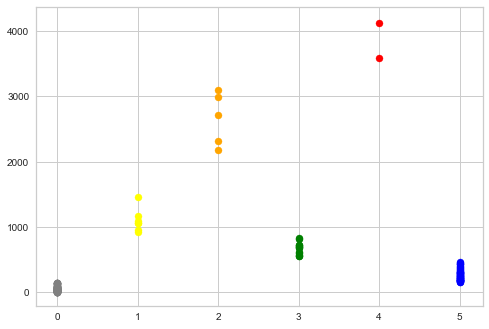

In [39]:
#plt.figure(figsize=(4,2),dpi=100)
plt.scatter(Y_data[Y_data==0],X_data[Y_data==0]["case_counts"].tolist(),s=50,c='gray',label='Cluster 1')
plt.scatter(Y_data[Y_data==1],X_data[Y_data==1]["case_counts"].tolist(),s=50,c='yellow',label='Cluster 2')
plt.scatter(Y_data[Y_data==2],X_data[Y_data==2]["case_counts"].tolist(),s=50,c='orange',label='Cluster 3')
plt.scatter(Y_data[Y_data==3],X_data[Y_data==3]["case_counts"].tolist(),s=50,c='green',label='Cluster 4')
plt.scatter(Y_data[Y_data==4],X_data[Y_data==4]["case_counts"].tolist(),s=50,c='red',label='Cluster 5')
plt.scatter(Y_data[Y_data==5],X_data[Y_data==5]["case_counts"].tolist(),s=50,c='blue',label='Cluster 5')

plt.show()
